# Deep learning
---------------------------

This example shows how we can use ATOM to train and validate a Convolutional Neural Network implemented using [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset with handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

<Figure size 432x288 with 0 Axes>

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=1, batch_size=512, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym='NN', fullname='Neural network')
model.type = 'deep'

In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

## Run the pipeline

In [5]:
atom = ATOMClassifier((X_train, y_train), (X_test, y_test), n_rows=0.1, n_jobs=4, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 4 cores.

Dataset stats ================== >>
Shape: (7000, 2)
Categorical columns: 1
Scaled: False
-----------------------------------
Train set size: 6000
Test set size: 1000
-----------------------------------
Train set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.1:1.3:1.1:1.1:1.0:1.0:1.1:1.1:1.2:1.1
Test set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.1:1.6:1.2:1.3:1.2:1.0:1.1:1.3:1.3:1.1
-----------------------------------
Distribution of classes:
|    |   dataset |   train |   test |
|---:|----------:|--------:|-------:|
|  0 |       678 |     587 |     91 |
|  1 |       839 |     710 |    129 |
|  2 |       691 |     589 |    102 |
|  3 |       705 |     601 |    104 |
|  4 |       644 |     547 |     97 |
|  5 |       617 |     535 |     82 |
|  6 |       695 |     607 |     88 |
|  7 |       717 |     609 |    108 |
|  8 |       741 |     635 |    106 |
|  9 |       673 |     5

In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
print(atom.dataset.head())
print(f"\nEvery row in the column contains the data of one image, with shape: {atom.dataset.iloc[0, 0].shape}")

                                            Features  target
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       9
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       3
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       3
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       8
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       1

Every row in the column contains the data of one image, with shape: (28, 28, 1)


In [7]:
# Like any other model, we can define custom dimensions for the bayesian optimization
dim = [Integer(1, 3, name="epochs"), Categorical([32, 64, 128, 256], name="batch_size")]

atom.run(model, metric="f1_weighted", n_calls=5, bo_params={"dimensions": dim, "cv": 1, "max_time": 120})


Training ===================================== >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
Initial point 1 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9617  Best f1_weighted: 0.9617
Time iteration: 12.105s   Total time: 12.109s
Initial point 2 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9524  Best f1_weighted: 0.9617
Time iteration: 9.052s   Total time: 21.161s
Initial point 3 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 32}
Evaluation --> f1_weighted: 0.9367  Best f1_weighted: 0.9617
Time iteration: 9.865s   Total time: 31.030s
Initial point 4 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9492  Best f1_weighted: 0.9617
Time iteration: 8.826s   Total time: 39.855s
Initial point 5 ---------------------------------
Parameters --> {'ep

## Analyze the results

In [8]:
# We can use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[5.0415245e-09, 8.9352969e-11, 2.6042830e-09, ..., 8.5581316e-12,
        4.2738580e-07, 3.3163179e-12],
       [9.9999940e-01, 6.9282345e-12, 1.5406499e-08, ..., 3.5452724e-11,
        3.1608752e-07, 3.0461987e-12],
       [7.0951058e-14, 1.2797069e-10, 7.0119080e-07, ..., 4.0664099e-07,
        3.9806758e-07, 2.4173743e-05],
       ...,
       [9.6390613e-12, 2.5091540e-11, 4.7392569e-15, ..., 3.2657363e-16,
        4.4298918e-08, 1.6538155e-11],
       [4.4590468e-04, 1.0565588e-12, 2.4052630e-07, ..., 2.7748465e-08,
        9.2415348e-10, 4.4087504e-11],
       [6.0453094e-05, 1.2410469e-07, 6.2073417e-07, ..., 5.6588982e-05,
        9.9985051e-01, 6.5946715e-06]], dtype=float32)

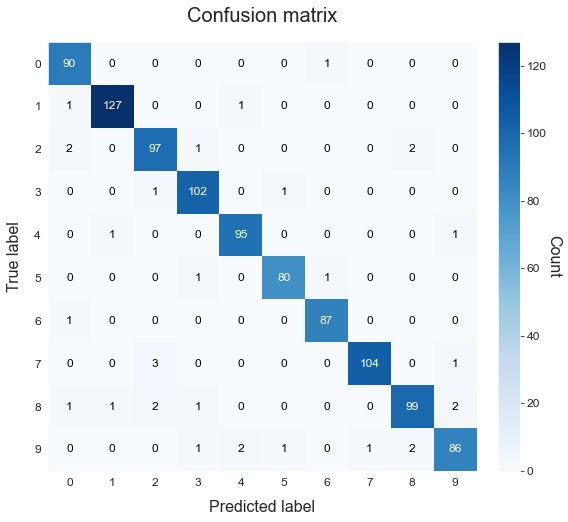

In [9]:
# Or make plots...
atom.nn.plot_confusion_matrix()